# View Graph For Indoor Navigation



## Test Environments
### Hypothetical Floor Plan (Basic)
<div>
<img src="envs/hypo_basic.png" width="500"/>
</div>

### Hypothetical Floor Plan
<div>
<img src="envs/hypo_advanced.png" width="500"/>
</div>

### Real World Environment (University Layout)
<div>
<img src="envs/mc5.png" width="500"/>
</div>


### Real World Environment (Regent Place Shopping Mall)
Constructed from - with minor simplification: https://www.regentplace.com.au/floor-plan
<div>
<img src="envs/regent_place.png" width="500"/>
</div>

### Test Environment Constructed From Liu and Zlatanova (2011)
<div>
<img src="envs/sisi.png" width="500"/>
</div>

## Setup

### Loading classes

In [1]:
# Parameters
from Parameters import Parameters

# Utitlies for mathematical calculation, isovist and visualization
from Isovist import Isovist
from Plotter import Plotter
from Utility import Utility

# Container -> Environment -> View Graph
from Container import Container
from Environment import IndoorEnvironment
from ViewGraph import ViewGraph

from pyvis.network import Network

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

### Variables and parameters

In [2]:
Parameters.set_env("real")
Parameters.print_info()

--------------------------------------
Real-world environment is active

Static Variables: 
	epsilon: 0.01
	precision: 2
	alpha: 40
	fov: 160
	min_area: 0.005
	max_distance: 1000000
	door_weight: 50
	turn_weight: 0.05
--------------------------------------


### Reading Datasets

In [3]:
def read_env():
    # Basic environment
    if Parameters.basic:
        address = 'envs/basic/'
        pfiles = ['t_bound.geojson']
        hfiles = [None]
        dfiles = ['t_doors.geojson']
        dpfiles = [None]
        lfiles = ['t_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # Hypo environment
    elif Parameters.hypo:
        address = 'envs/hypo/'
        pfiles = ['hypo_env.geojson']
        hfiles = ['hypo_holes.geojson']
        dfiles = ['hypo_doors.geojson']
        dpfiles = ['hypo_dpoints.geojson']
        lfiles = ['hypo_landmarks.geojson']
        # create an indoor environment
        ie = IndoorEnvironment(address, pfiles, hfiles, dfiles, dpfiles, lfiles)

    # MC5 real world environment
    else:
        if Parameters.mc:
            address = 'envs/mc-floor-5/'
        else:
            address = 'envs/RegentPlace'
        pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
            address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
        # create an indoor environment
        ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)
    
    return ie

## University Layout

In [4]:
%%capture --no-display
ie = read_env()

## Creating View Graph

In [5]:
%%capture --no-display
# create view graph
vgs, isovist_objects = ie.construct_view_graph()

In [6]:
ie.containers_names

['Emergency Stairs',
 'Women Toilet',
 'Disabled Toilet',
 'Men Toilet',
 'Corridor',
 'Active Hub',
 'Stairs to Lower Floors',
 'Ngi-a Djerring Gat-ith',
 'UX Lab']

### Shortest Path and Route Instruction

In [7]:
# set parameters to Parameters class
start_container = 'Women Toilet'
start_region = 3
end_container = 'Active Hub'
end_region = 3

enter: Corridor
enter: Active Hub


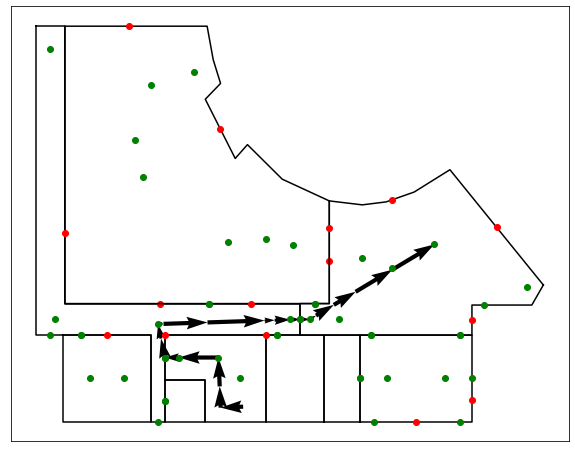

<Figure size 720x576 with 0 Axes>

In [8]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

In [9]:
# generate route instructions
def generate_route_descriptions(vp):
    container = ''
    container_vids = {}
    finals = {}
    for v in vp[1:-1]:
        info = v.split('-V')
        if container != info[0]:
            container = info[0]
            container_vids[container] = []
        container_vids[container].append(int(info[1]))
    for container, vids in container_vids.items():
        cidx = ie.containers_names.index(container)
        vg = vgs[cidx]
        rds = vg.generate_route_description(vids)
        finals[container] = rds
    return finals

def print_route_descriptions(rd_dictionary):
    containers = list(rd_dictionary.keys())
    for container in containers:
        rd = rd_dictionary[container]
        if containers.index(container) < len(containers) - 1:
            rd[len(rd)-1] = rd[len(rd)-1].replace('until you reach the destination', 'to enter {}'.format(containers[containers.index(container)+1]))
        for r in rd:
            print(r)
# vg.generate_route_description(vp)
print_route_descriptions(generate_route_descriptions(vp))

Head towards decision point 1 and turn left
Pass decision point 1 and move forward to enter Corridor
Head towards the door to women toilet
Pass the door to women toilet and veer right
Pass the door to male toilet and move forward to enter Active Hub
Head towards the door to corridor
Pass the landmark 0 and move forward until you reach the destination


### Derive Door-to-Door Visibility Graph

In [10]:
# selecting a space
cidx = ie.containers_names.index('Active Hub')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph
Press Enter: Door to door visibility (doors+gateways)


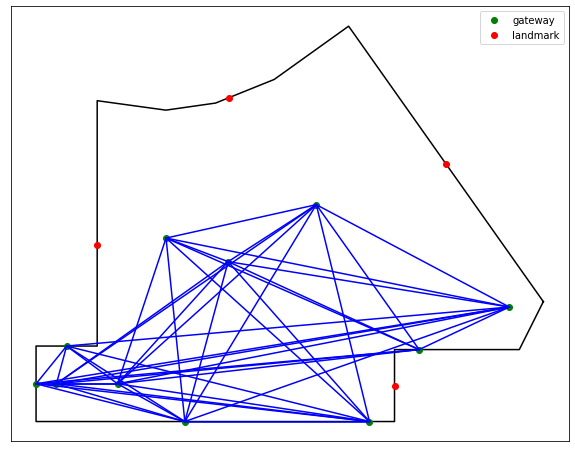

<Figure size 720x576 with 0 Axes>

In [11]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

print('Press Enter: Door to door visibility (doors+gateways)')
plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

### Generate door-to-door visibility graph (only for doors)

generate door-to-door graph, only_doors True from view graph


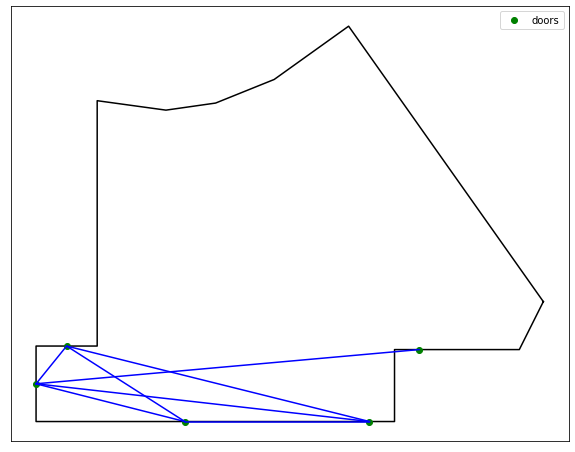

<Figure size 720x576 with 0 Axes>

In [12]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()


### Generate Place Graph

In [14]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [15]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

In [16]:
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


### Single Nplet
Select a single n-plet from different spatial relationships and visualize the graph and spatial configuration

1. between
2. near
3. left/right

In [17]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

def nplet_extraction(nplet_id):
    ## nplet_id = 'n830'
    place_graph[nplet_id]  # left
    # place_graph['n100'] # between

    # nodes = ['n830', 'left', 'place12', 'gateway 12', 'landmark 20', 'gateway 1']
    nodes = [nplet_id]
    nodes.extend(list(dict(place_graph[nplet_id]).keys()))

    additional = []
    for node in nodes:
        if node.startswith('place'):
            additional.extend(list(dict(place_graph[node]).keys()))
    nodes.extend(additional)

    for v in list(place_graph.edges):
        if v[1] == nplet_id:
            nodes.append(v[0])
            if v[0].startswith('place'):
                nodes.extend(list(dict(place_graph[v[0]]).keys()))

    nplets = place_graph.subgraph(nodes)
    nt2 = Network(width='1000px', height='600px', directed=True, notebook=True)
    nt2.from_nx(nplets, show_edge_weights=False)
    nt2.options.physics.use_repulsion({'node_distance': 185, 'central_gravity': 0.2, 'spring_length': 200,
                                        'spring_strength': 0.05, 'damping': 0.09})
    return nt2, nodes

spatial_expression = 'the door to women toilet between the landmark 2 and the door to disabled toilet'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')


## Regent Place - Shopping Mall

Testing the view graph capabilities in computing shortest path, generating route descriptions, navigation graphs and place graphs in another test environment: Regenet Place Shopping Mall (https://www.regentplace.com.au/floor-plan)

### Reading the Floorplan Files

In [18]:
%%capture --no-display
# reading the new floorplan dataset
Parameters.set_env(env="real", mc=False)
address = 'envs/RegentPlace/'
pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
    address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
# create an indoor environment
ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)

### Creating View Graph

In [19]:
%%capture --no-display
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()

### Shortest Path and Route Instruction

In [20]:
ie.containers_names

['Ice Kirin Bar',
 'Shop',
 'Fireside By Yunn',
 'Yakitori Yokocho',
 'Loading Dock',
 'Fujimi Bakehouse',
 'Daiso',
 'The Parks Sydney',
 'Mido Mart',
 'Toilet',
 'Yakinku Yokocho',
 'Dioa by Devon',
 'Arctic White',
 'Edomae Sushi',
 'FraserSuites',
 'Corridor']

In [21]:
# set parameters to Parameters class
start_container = 'Ice Kirin Bar'
start_region = 0
end_container = 'Daiso'
end_region = 1

enter: Corridor
enter: Daiso


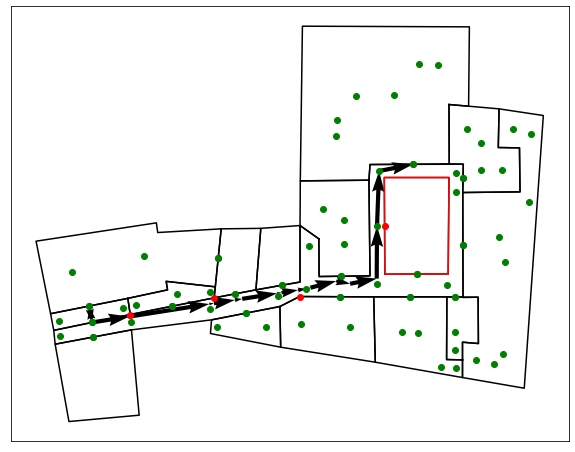

<Figure size 720x576 with 0 Axes>

In [22]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

In [23]:
print_route_descriptions(generate_route_descriptions(vp))

Head towards the door to Corridor and move forward to enter Corridor
Head towards the door to Ice Kirin Bar
Pass decision point 11 and turn left
Follow decision point 7 on the front and turn right and move forward until you reach the destination


### Creating Navigation Graphs - Door-to-Door

In [24]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph


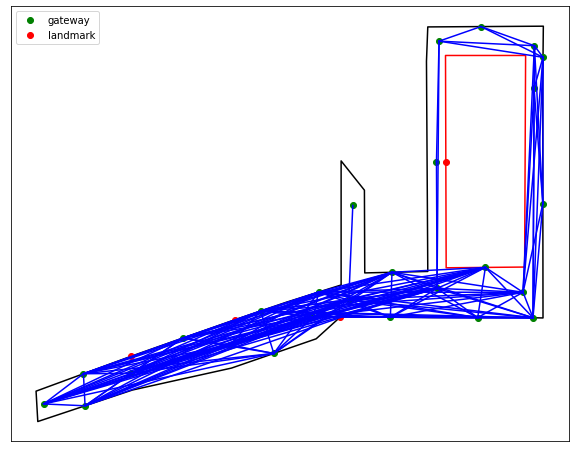

<Figure size 720x576 with 0 Axes>

In [25]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

generate door-to-door graph, only_doors True from view graph


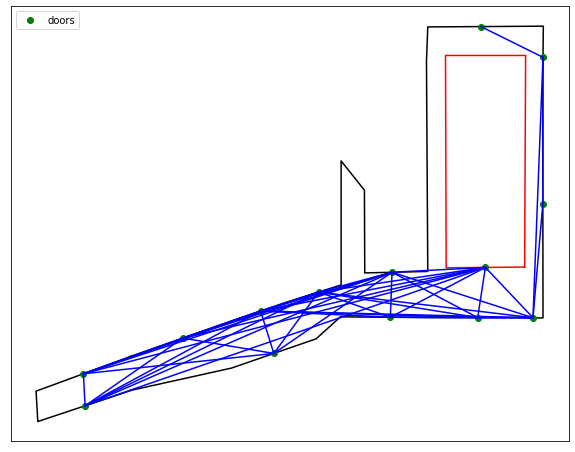

<Figure size 720x576 with 0 Axes>

In [26]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

### Creating Place Graph

In [27]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [28]:
# selecting a space
cidx = ie.containers_names.index('Corridor')
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

spatial_expression = 'the landmark 1 between the door to Fireside By Yunn and the door to Fujimi Bakehouse'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

## Hypothetical Floorplan (with holes)

In [29]:
%%capture --no-display
Parameters.set_env(env="hypo", mc=False)
ie = read_env()

### Creating View Graph

In [30]:
%%capture --no-display
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()

### Shortest Path and Route Instruction

In [31]:
# set parameters to Parameters class
start_container = 'Container'
start_region = 0
end_container = 'Container'
end_region = 60

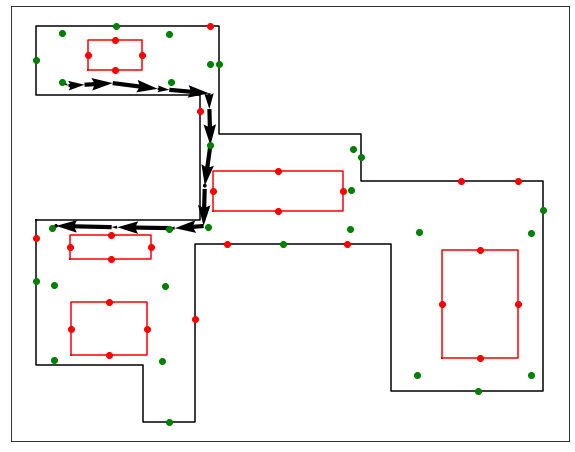

<Figure size 720x576 with 0 Axes>

In [32]:
# calculate shortest path and generate verbal description
vp, pv = ie.shortest_path(start_container, start_region, end_container, end_region)

# plot shortest path
plotter = Plotter()
for isovist_object in ie.isovist_objects:
    plotter.add_isovist(isovist_object)
plotter.add_views(pv)
plotter.show(False)
plotter.close()

### Generating Route Descriptions

In [33]:
print_route_descriptions(generate_route_descriptions(vp))

Head towards the landmark 21
Pass the landmark 21 and turn right
Pass the landmark 18 and turn right
Pass decision point 15 and move forward until you reach the destination


### Creating Navigation Graphs

In [34]:
# selecting a space
cidx = 0
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

generate door-to-door graph, only_doors False from view graph


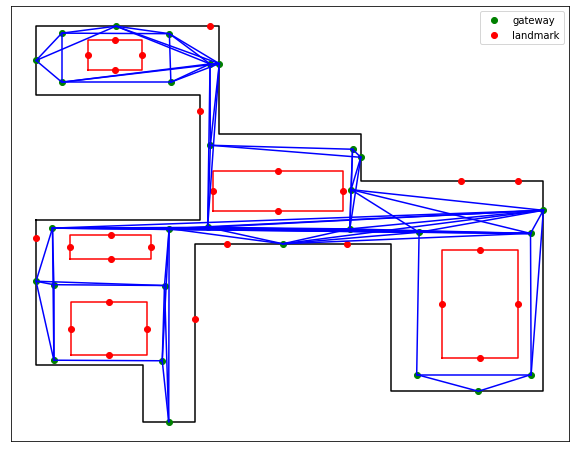

<Figure size 720x576 with 0 Axes>

In [35]:
# derive door-to-door visibility graph (doors and decision points)
connected, dtd_graph = vg.generate_door_to_door_graph(isovist_object)

plotter = Plotter()
plotter.add_isovist(isovist_object)
plotter.add_points_lines(connected)
plotter.show()
plotter.close()

generate door-to-door graph, only_doors True from view graph


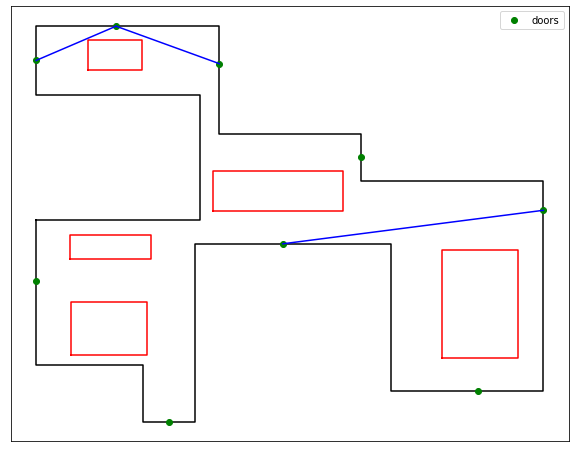

<Figure size 720x576 with 0 Axes>

In [36]:
# derive door-to-door visibility graph (only doors)
connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=True)
plotter = Plotter()
plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
plotter.add_points(isovist_object.door_points[:isovist_object.door_idx], 'doors')
plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

### Creating Place Graphs

In [37]:
# derive place graph
place_graph = vg.generate_place_graph(isovist_object)

derive place graph from view graph


In [38]:
# selecting a space
cidx = 0
vg = vgs[cidx]
isovist_object = isovist_objects[cidx]

spatial_expression = 'door 4 between the landmark 8 and the landmark 26'
for n in place_graph.nodes:
    if n.startswith('n') and 'exp' in place_graph.nodes[n].keys() and place_graph.nodes[n]['exp'] == spatial_expression:
        nplet = n
        break
nt2, nplet_nodes = nplet_extraction(nplet)
nt2.show('nplet_1.html')

## Hypothetical Environment

### constructed from Liu and Zlatanova (2011)

In [39]:
%%capture --no-display
# reading the new floorplan dataset
Parameters.set_env(env="real", mc=True)
address = 'envs/paper/'
pfiles, hfiles, dfiles, dpfiles, lfiles = IndoorEnvironment.reformat(
    address, 'containers.geojson', 'doors.geojson', 'landmarks.geojson')
# create an indoor environment
ie = IndoorEnvironment('', pfiles, hfiles, dfiles, dpfiles, lfiles)

In [40]:
ie.containers_names

['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11']

## View Graph Construction

In [41]:
%%capture --no-display
# creating view graph
vgs, isovist_objects = ie.construct_view_graph()

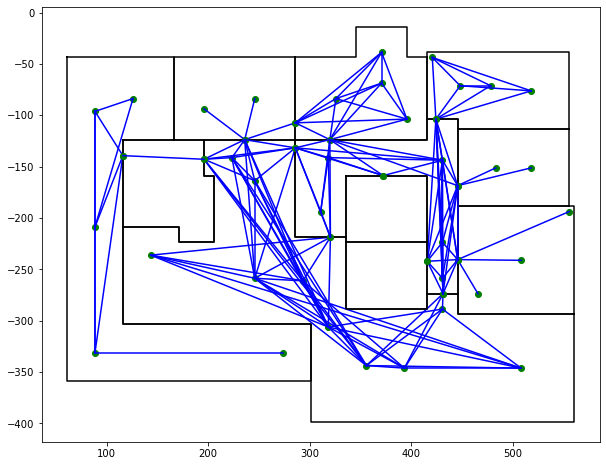

In [42]:
%%capture --no-display
# derive door-to-door visibility graph (doors+gateways)
plotter = Plotter()
for idx,vg in enumerate(vgs):
    isovist_object = isovist_objects[idx]
    connected2, dtd_graph2 = vg.generate_door_to_door_graph(isovist_object, only_doors=False)
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    plotter.add_points(isovist_object.door_points, 'gateways')
    plotter.add_points_lines(connected2)
plotter.show()
plotter.close()

### Computing Shortest Path Using Door-to-Door Graph

In [44]:
gids = Utility.global_gateway_ids(ie)
gids
gids_rev = {}
for cname, vals in gids.items():
    for did, gid in vals.items():
        if gid not in gids_rev:
            gids_rev[gid] = []
        gids_rev[gid].append({'container': cname, 'did': did})

In [45]:
%%capture --no-display
door_to_door_graph = Utility.generate_door_to_door_graph(ie)

In [46]:
container = 'c11'
door_id = 1
container2 = 'c6'
door_id2 = 0

import networkx as nx
path = nx.shortest_path(door_to_door_graph,gids[container][door_id], gids[container2][door_id2])

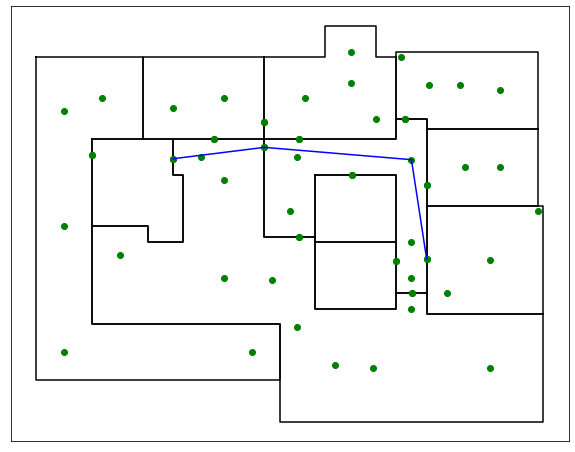

<Figure size 720x576 with 0 Axes>

In [47]:
plotter = Plotter()
for idx,vg in enumerate(vgs):
    isovist_object = isovist_objects[idx]
    plotter.add_poly(isovist_object.space_x, isovist_object.space_y)
    plotter.add_holes(isovist_object.holes_x, isovist_object.holes_y)
    plotter.add_points(isovist_object.door_points, 'gateways')
for idx, gid in enumerate(path[:-1]):
    gid2 = path[idx+1]
    c1 = ie.isovist_objects[ie.containers_names.index(gids_rev[gid][0]['container'])].door_points[gids_rev[gid][0]['did']]
    c2 = ie.isovist_objects[ie.containers_names.index(gids_rev[gid2][0]['container'])].door_points[gids_rev[gid2][0]['did']]
    plotter.add_points_lines([[c1, c2]])
plotter.show(False)
plotter.close()